In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os

# Step 1: Define the Dataset
class AccidentDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images, self.labels = self.load_images()

    def load_images(self):
        images, labels = [], []
        for label, folder in enumerate(['Non Accident', 'Accident']):
            folder_path = os.path.join(self.data_dir, folder)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                images.append(img_path)
                labels.append(label)
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Step 2: Define the Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust image size for models like MobileNetV2
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # MobileNet normalization
])

# Load Dataset
data_dir = '/content/drive/MyDrive/datasetcap2/road_accident_dataset/'
full_train_dataset = AccidentDataset(data_dir + 'train', transform=transform)
val_dataset = AccidentDataset(data_dir + 'val', transform=transform)

# Reduce the training set size for faster experimentation
train_size = int(0.3 * len(full_train_dataset))
train_dataset, _ = random_split(full_train_dataset, [train_size, len(full_train_dataset) - train_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Step 3: Define Model Names
model_names = ['resnet18', 'mobilenet_v2', 'efficientnet_b0']

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Store Results
results = []

for model_name in model_names:
    print(f"Training {model_name}...")

    # Step 4: Load the Model
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 1)
    elif model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

    model = model.to(device)

    # Step 5: Define Loss Function, Optimizer, and Scheduler
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

    # Step 6: Train and Validate the Model
    num_epochs = 5
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct = 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            correct += (preds == labels).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / len(train_loader.dataset))

        # Validation Loop
        model.eval()
        val_running_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels.float())
                val_running_loss += loss.item()
                preds = torch.round(torch.sigmoid(outputs))
                val_correct += (preds == labels).sum().item()

        val_loss.append(val_running_loss / len(val_loader))
        val_acc.append(val_correct / len(val_loader.dataset))

        print(f'{model_name} Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}')

        scheduler.step()

    # Step 7: Save the Results
    results.append({
        'model_name': model_name,
        'train_loss': train_loss[-1],
        'val_loss': val_loss[-1],
        'train_acc': train_acc[-1],
        'val_acc': val_acc[-1],
    })

    # Optionally Save the Model
    torch.save(model.state_dict(), f'/content/drive/MyDrive/{model_name}_finetuned.pth')

# Step 8: Print the Comparative Results
print("\nComparative Analysis Results:")
for result in results:
    print(f"Model: {result['model_name']}, Train Loss: {result['train_loss']:.4f}, Val Loss: {result['val_loss']:.4f}, Train Acc: {result['train_acc']:.4f}, Val Acc: {result['val_acc']:.4f}")


Training resnet18...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:15<00:00, 3.12MB/s]


resnet18 Epoch 1/5, Train Loss: 0.6716, Val Loss: 0.5564, Train Acc: 0.5696, Val Acc: 0.7143
resnet18 Epoch 2/5, Train Loss: 0.5036, Val Loss: 0.4196, Train Acc: 0.7468, Val Acc: 0.8163
resnet18 Epoch 3/5, Train Loss: 0.4108, Val Loss: 0.3111, Train Acc: 0.8228, Val Acc: 0.8469
resnet18 Epoch 4/5, Train Loss: 0.3197, Val Loss: 0.3112, Train Acc: 0.8945, Val Acc: 0.8571
resnet18 Epoch 5/5, Train Loss: 0.3322, Val Loss: 0.3530, Train Acc: 0.8819, Val Acc: 0.8061
Training mobilenet_v2...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 80.7MB/s]


mobilenet_v2 Epoch 1/5, Train Loss: 0.6703, Val Loss: 0.6487, Train Acc: 0.5738, Val Acc: 0.6531
mobilenet_v2 Epoch 2/5, Train Loss: 0.5455, Val Loss: 0.5144, Train Acc: 0.7511, Val Acc: 0.8265
mobilenet_v2 Epoch 3/5, Train Loss: 0.4628, Val Loss: 0.4054, Train Acc: 0.7932, Val Acc: 0.8571
mobilenet_v2 Epoch 4/5, Train Loss: 0.3981, Val Loss: 0.4259, Train Acc: 0.8523, Val Acc: 0.8163
mobilenet_v2 Epoch 5/5, Train Loss: 0.3937, Val Loss: 0.3956, Train Acc: 0.8354, Val Acc: 0.8061
Training efficientnet_b0...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 87.5MB/s]


efficientnet_b0 Epoch 1/5, Train Loss: 0.6966, Val Loss: 0.7049, Train Acc: 0.5063, Val Acc: 0.5918
efficientnet_b0 Epoch 2/5, Train Loss: 0.6422, Val Loss: 0.6249, Train Acc: 0.7342, Val Acc: 0.7143
efficientnet_b0 Epoch 3/5, Train Loss: 0.5823, Val Loss: 0.5703, Train Acc: 0.7722, Val Acc: 0.7857
efficientnet_b0 Epoch 4/5, Train Loss: 0.5476, Val Loss: 0.5520, Train Acc: 0.8186, Val Acc: 0.8265
efficientnet_b0 Epoch 5/5, Train Loss: 0.5465, Val Loss: 0.5450, Train Acc: 0.8143, Val Acc: 0.7755

Comparative Analysis Results:
Model: resnet18, Train Loss: 0.3322, Val Loss: 0.3530, Train Acc: 0.8819, Val Acc: 0.8061
Model: mobilenet_v2, Train Loss: 0.3937, Val Loss: 0.3956, Train Acc: 0.8354, Val Acc: 0.8061
Model: efficientnet_b0, Train Loss: 0.5465, Val Loss: 0.5450, Train Acc: 0.8143, Val Acc: 0.7755


graph and report

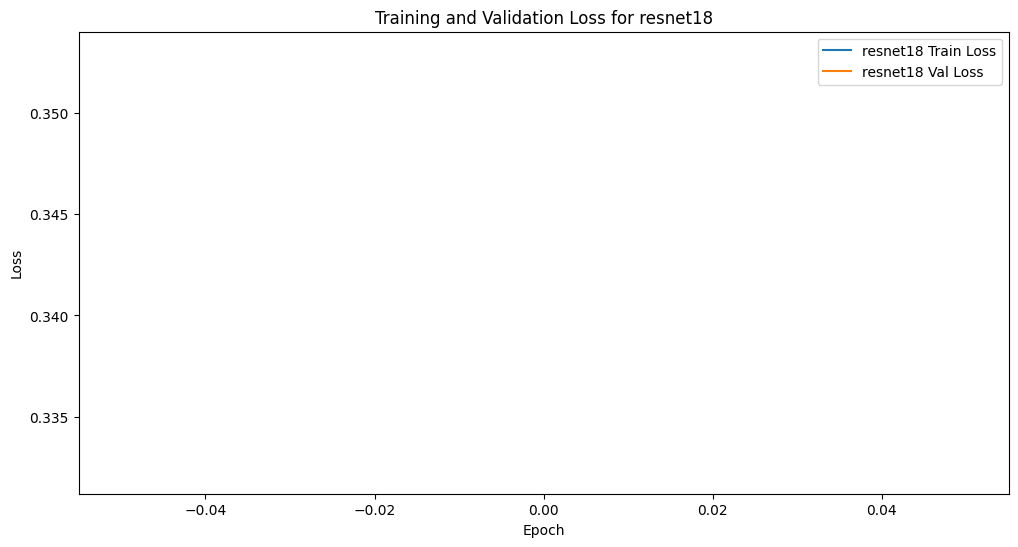

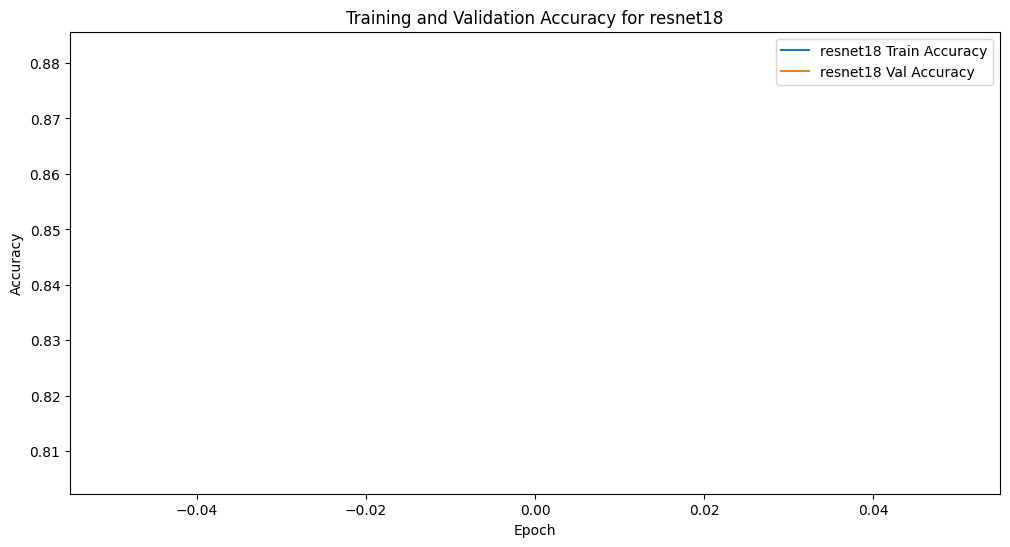

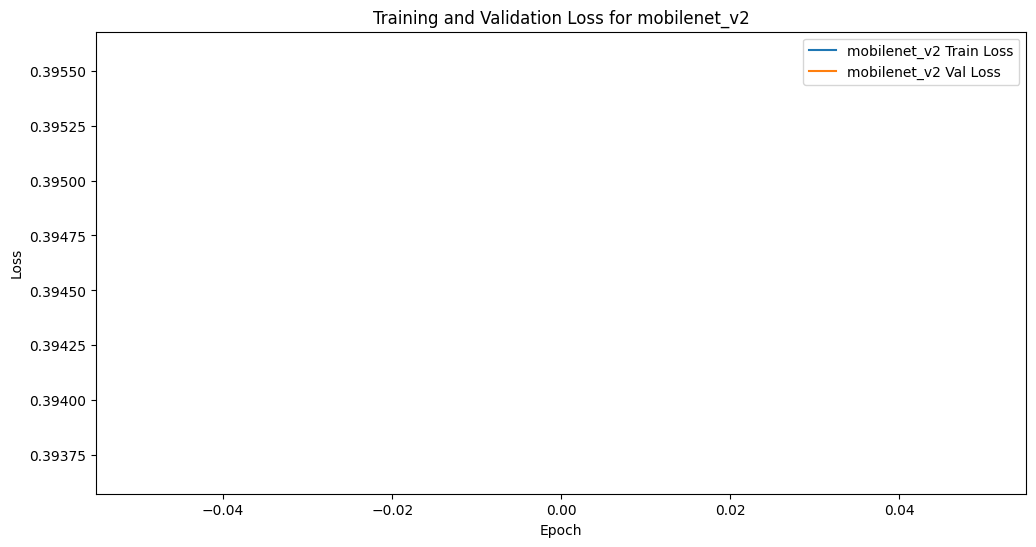

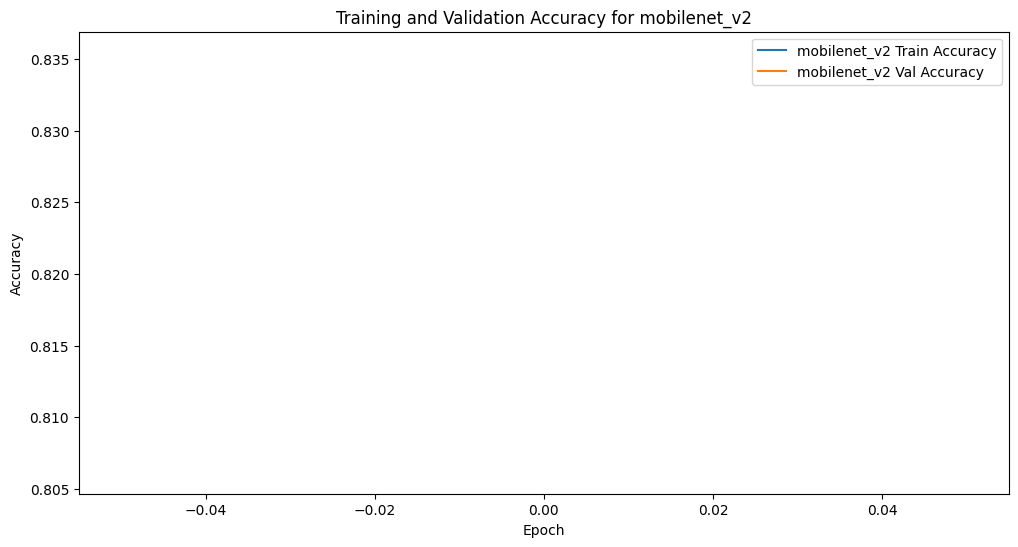

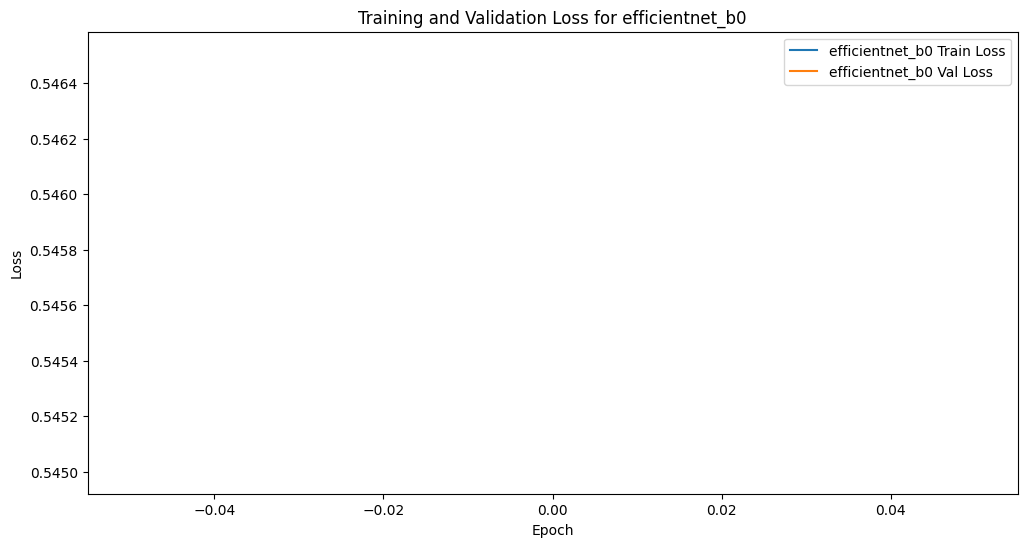

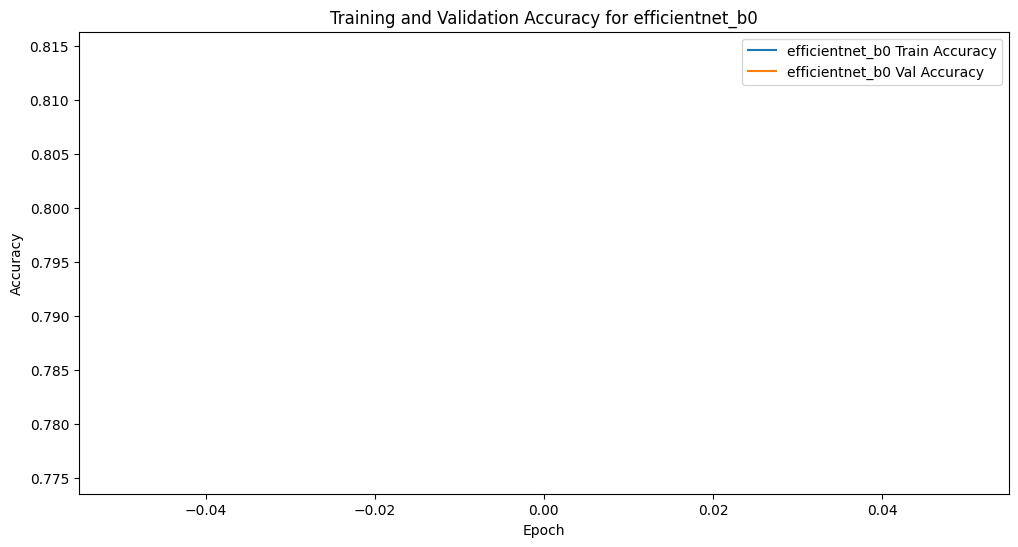


Generating Classification Report and Confusion Matrix for resnet18...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Classification Report for resnet18:
              precision    recall  f1-score   support

Non Accident       0.82      0.87      0.84        52
    Accident       0.84      0.78      0.81        46

    accuracy                           0.83        98
   macro avg       0.83      0.82      0.83        98
weighted avg       0.83      0.83      0.83        98



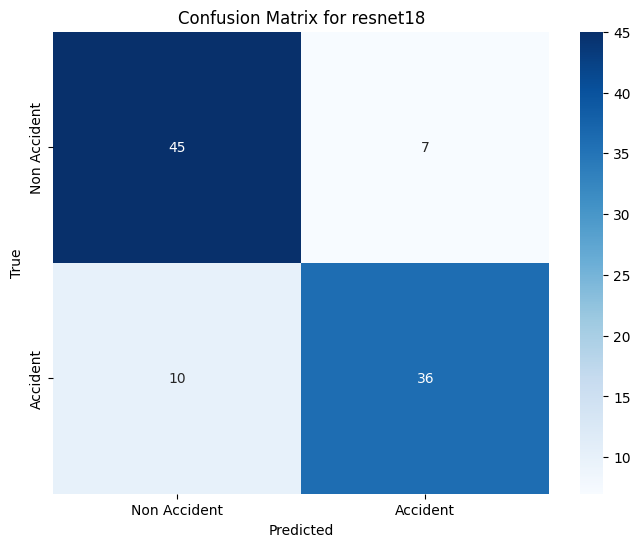


Generating Classification Report and Confusion Matrix for mobilenet_v2...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Classification Report for mobilenet_v2:
              precision    recall  f1-score   support

Non Accident       0.88      0.81      0.84        52
    Accident       0.80      0.87      0.83        46

    accuracy                           0.84        98
   macro avg       0.84      0.84      0.84        98
weighted avg       0.84      0.84      0.84        98



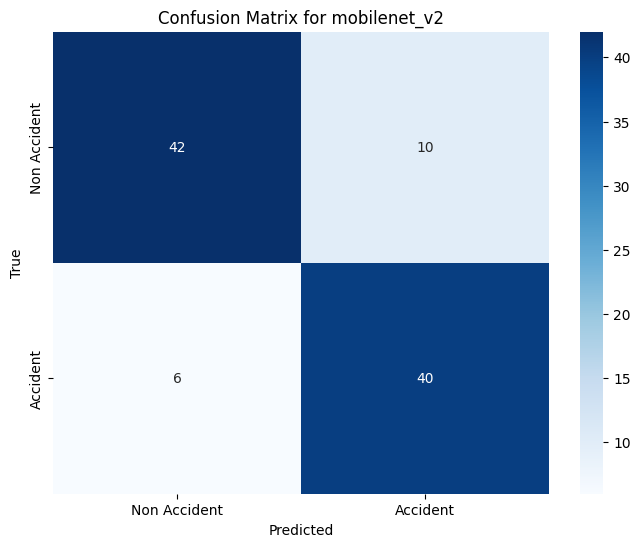


Generating Classification Report and Confusion Matrix for efficientnet_b0...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Classification Report for efficientnet_b0:
              precision    recall  f1-score   support

Non Accident       0.80      0.87      0.83        52
    Accident       0.83      0.76      0.80        46

    accuracy                           0.82        98
   macro avg       0.82      0.81      0.81        98
weighted avg       0.82      0.82      0.82        98



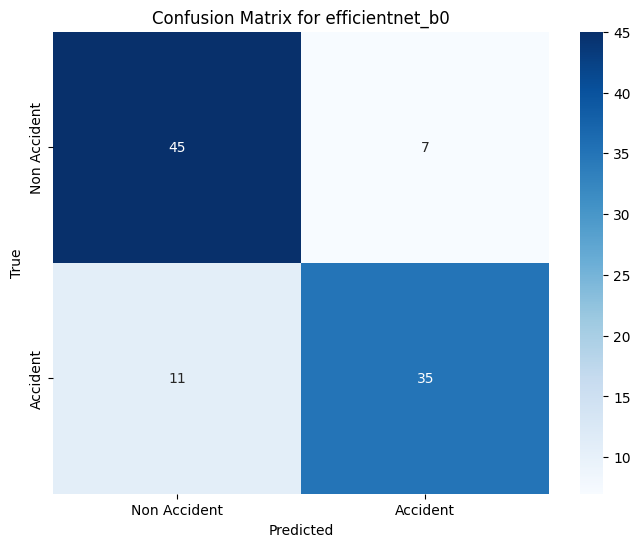

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Assume `model_paths` is a list of paths where each model was saved
model_paths = [f'/content/drive/MyDrive/{result["model_name"]}_finetuned.pth' for result in results]

# Plot Accuracy and Loss Graphs
for result in results:
    model_name = result['model_name']

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.plot(result['train_loss'], label=f'{model_name} Train Loss')
    plt.plot(result['val_loss'], label=f'{model_name} Val Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(result['train_acc'], label=f'{model_name} Train Accuracy')
    plt.plot(result['val_acc'], label=f'{model_name} Val Accuracy')
    plt.title(f'Training and Validation Accuracy for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Generate Classification Report and Confusion Matrix for Each Model
for i, model_path in enumerate(model_paths):
    model_name = results[i]['model_name']
    print(f'\nGenerating Classification Report and Confusion Matrix for {model_name}...')

    # Reload the model
    if 'resnet' in model_name:
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, 1)
    elif 'mobilenet' in model_name:
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    elif 'efficientnet' in model_name:
        model = models.efficientnet_b0(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()

    # Gather predictions and true labels
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # Print classification report
    print(f'\nClassification Report for {model_name}:')
    print(classification_report(all_labels, all_preds, target_names=['Non Accident', 'Accident']))

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non Accident', 'Accident'], yticklabels=['Non Accident', 'Accident'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


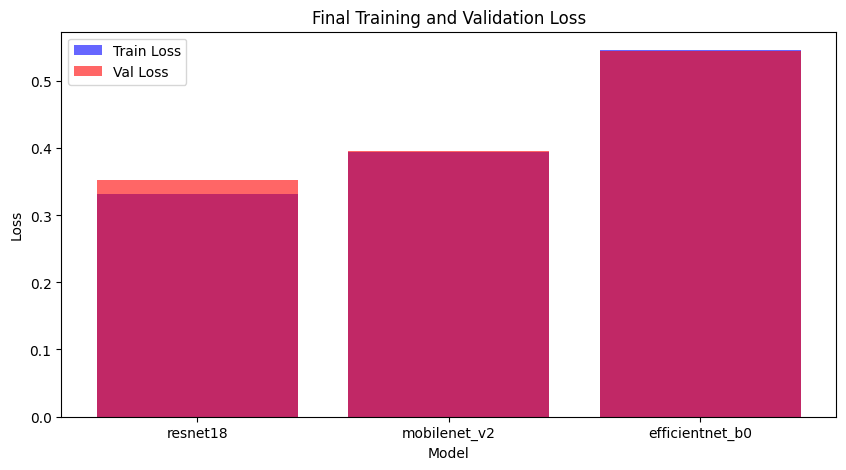

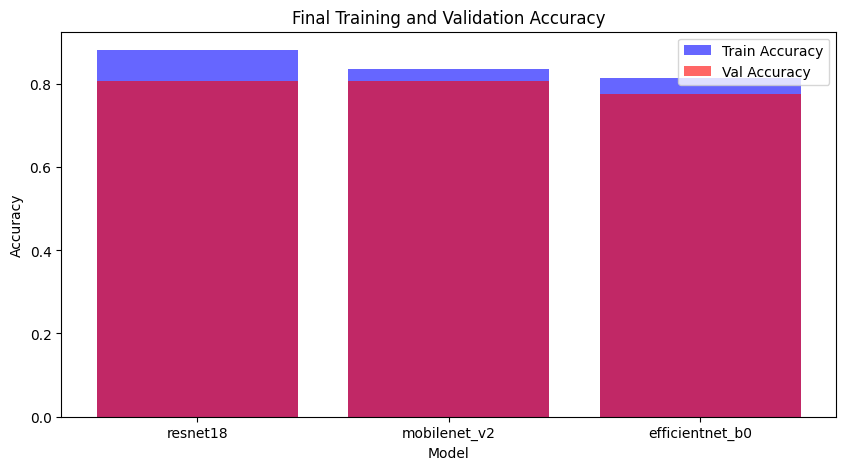

In [15]:
import matplotlib.pyplot as plt

# Extract final metrics for plotting
model_names = [result['model_name'] for result in results]
train_losses = [result['train_loss'] for result in results]
val_losses = [result['val_loss'] for result in results]
train_accuracies = [result['train_acc'] for result in results]
val_accuracies = [result['val_acc'] for result in results]

# Plot Final Losses
plt.figure(figsize=(10, 5))
plt.bar(model_names, train_losses, color='blue', alpha=0.6, label='Train Loss')
plt.bar(model_names, val_losses, color='red', alpha=0.6, label='Val Loss')
plt.title('Final Training and Validation Loss')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Final Accuracies
plt.figure(figsize=(10, 5))
plt.bar(model_names, train_accuracies, color='blue', alpha=0.6, label='Train Accuracy')
plt.bar(model_names, val_accuracies, color='red', alpha=0.6, label='Val Accuracy')
plt.title('Final Training and Validation Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


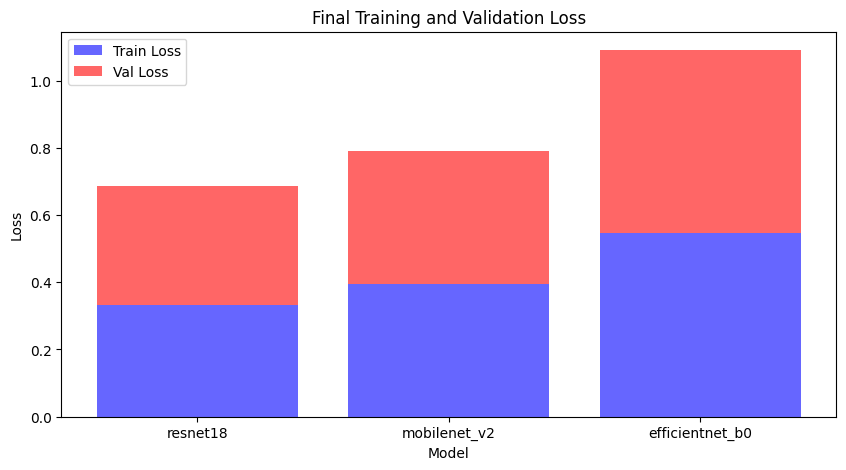

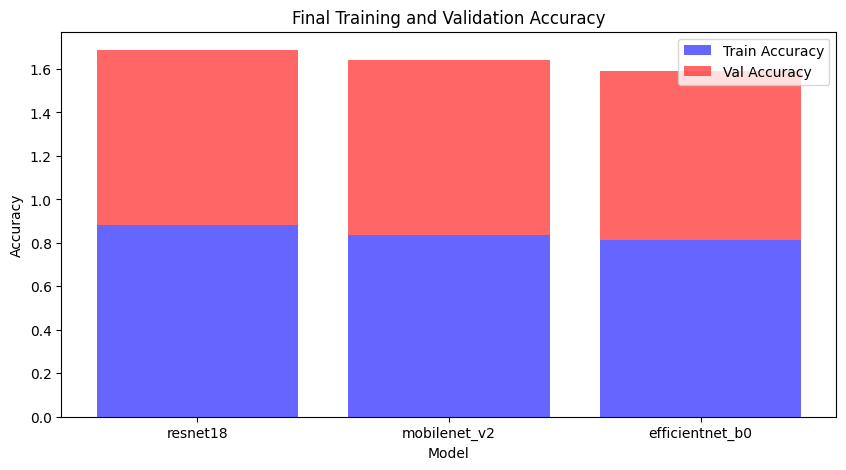

In [16]:
import matplotlib.pyplot as plt

# Extract final metrics for plotting
model_names = [result['model_name'] for result in results]
train_losses = [result['train_loss'] for result in results]
val_losses = [result['val_loss'] for result in results]
train_accuracies = [result['train_acc'] for result in results]
val_accuracies = [result['val_acc'] for result in results]

# Plot Final Losses
plt.figure(figsize=(10, 5))
plt.bar(model_names, train_losses, color='blue', alpha=0.6, label='Train Loss')
plt.bar(model_names, val_losses, color='red', alpha=0.6, label='Val Loss', bottom=train_losses)
plt.title('Final Training and Validation Loss')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Final Accuracies
plt.figure(figsize=(10, 5))
plt.bar(model_names, train_accuracies, color='blue', alpha=0.6, label='Train Accuracy')
plt.bar(model_names, val_accuracies, color='red', alpha=0.6, label='Val Accuracy', bottom=train_accuracies)
plt.title('Final Training and Validation Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


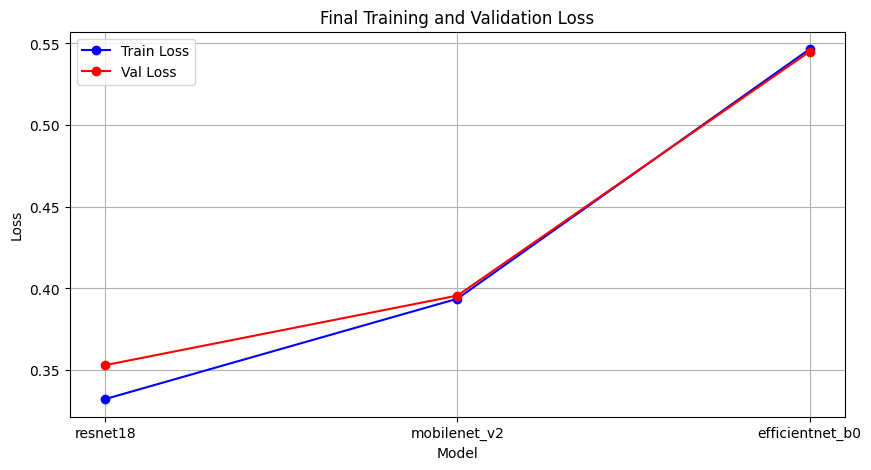

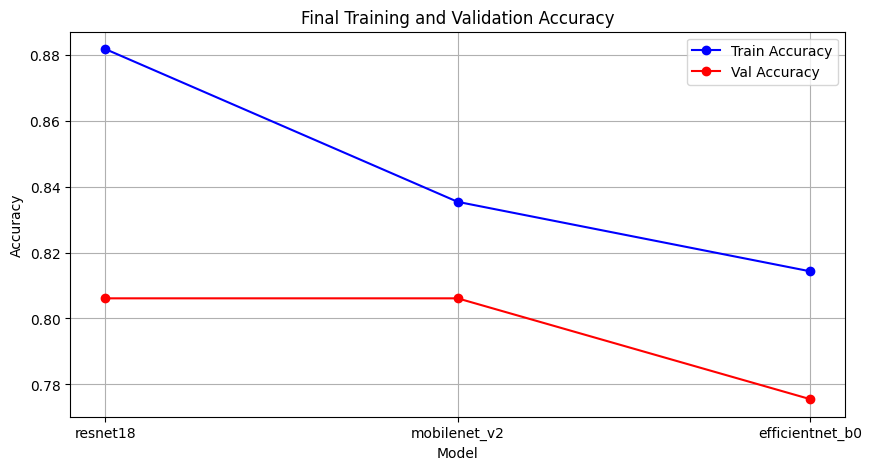

In [17]:
import matplotlib.pyplot as plt

# Plot Final Losses as Points
plt.figure(figsize=(10, 5))
plt.plot(model_names, train_losses, 'bo-', label='Train Loss')
plt.plot(model_names, val_losses, 'ro-', label='Val Loss')
plt.title('Final Training and Validation Loss')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Final Accuracies as Points
plt.figure(figsize=(10, 5))
plt.plot(model_names, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(model_names, val_accuracies, 'ro-', label='Val Accuracy')
plt.title('Final Training and Validation Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


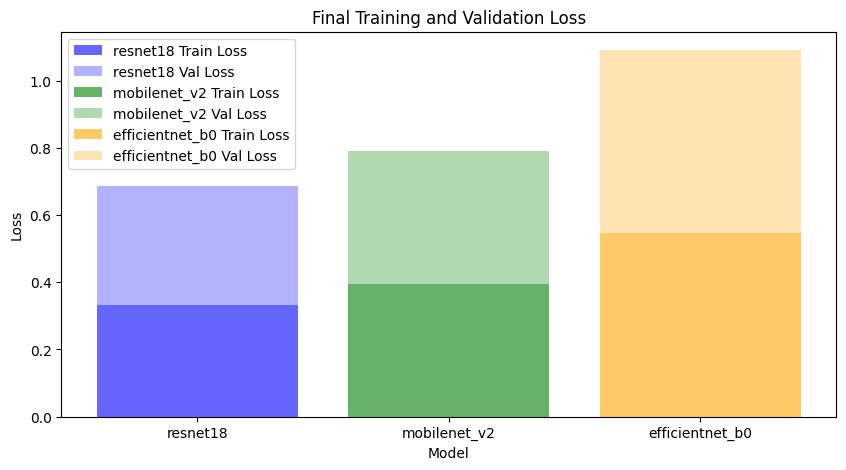

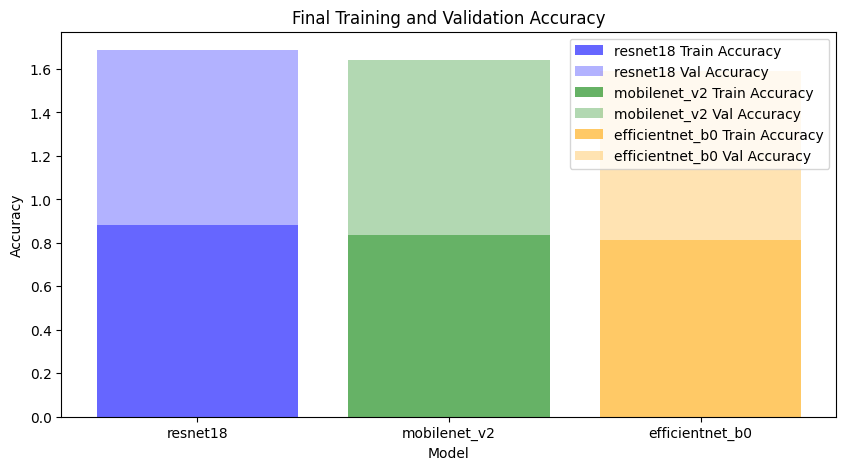

In [18]:
import matplotlib.pyplot as plt

# Extract final metrics for plotting
model_names = [result['model_name'] for result in results]
train_losses = [result['train_loss'] for result in results]
val_losses = [result['val_loss'] for result in results]
train_accuracies = [result['train_acc'] for result in results]
val_accuracies = [result['val_acc'] for result in results]

# Colors for each model
colors = ['blue', 'green', 'orange']

# Plot Final Losses as Bar Chart
plt.figure(figsize=(10, 5))
for i, model_name in enumerate(model_names):
    plt.bar(model_name, train_losses[i], color=colors[i], alpha=0.6, label=f'{model_name} Train Loss')
    plt.bar(model_name, val_losses[i], color=colors[i], alpha=0.3, label=f'{model_name} Val Loss', bottom=train_losses[i])
plt.title('Final Training and Validation Loss')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Final Accuracies as Bar Chart
plt.figure(figsize=(10, 5))
for i, model_name in enumerate(model_names):
    plt.bar(model_name, train_accuracies[i], color=colors[i], alpha=0.6, label=f'{model_name} Train Accuracy')
    plt.bar(model_name, val_accuracies[i], color=colors[i], alpha=0.3, label=f'{model_name} Val Accuracy', bottom=train_accuracies[i])
plt.title('Final Training and Validation Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


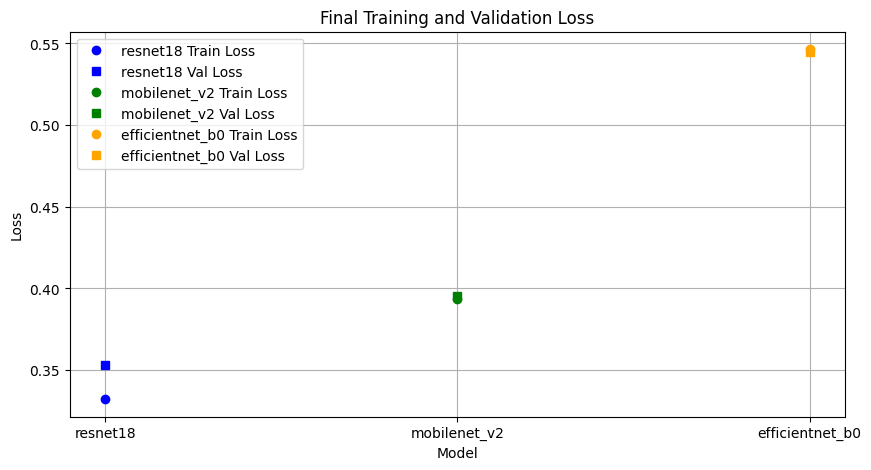

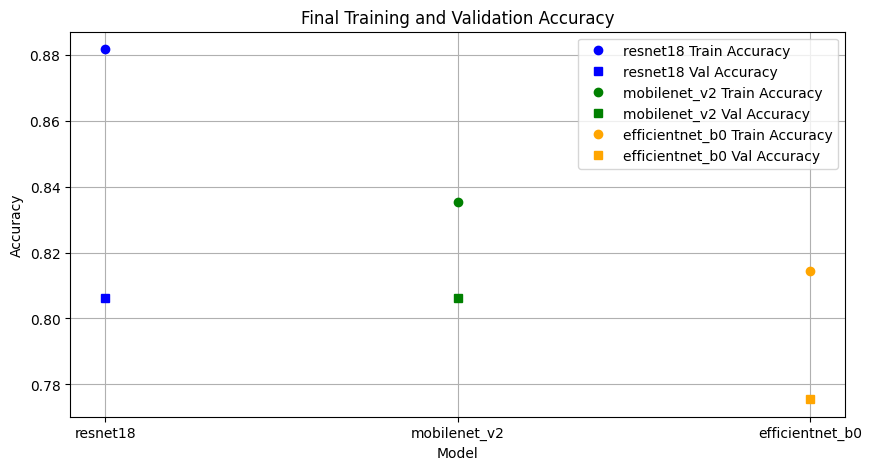

In [19]:
import matplotlib.pyplot as plt

# Extract final metrics for plotting
model_names = [result['model_name'] for result in results]
train_losses = [result['train_loss'] for result in results]
val_losses = [result['val_loss'] for result in results]
train_accuracies = [result['train_acc'] for result in results]
val_accuracies = [result['val_acc'] for result in results]

# Colors for each model
colors = ['blue', 'green', 'orange']

# Plot Final Losses as Points
plt.figure(figsize=(10, 5))
for i, model_name in enumerate(model_names):
    plt.plot([model_name], [train_losses[i]], 'o', color=colors[i], label=f'{model_name} Train Loss')
    plt.plot([model_name], [val_losses[i]], 's', color=colors[i], label=f'{model_name} Val Loss')
plt.title('Final Training and Validation Loss')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Final Accuracies as Points
plt.figure(figsize=(10, 5))
for i, model_name in enumerate(model_names):
    plt.plot([model_name], [train_accuracies[i]], 'o', color=colors[i], label=f'{model_name} Train Accuracy')
    plt.plot([model_name], [val_accuracies[i]], 's', color=colors[i], label=f'{model_name} Val Accuracy')
plt.title('Final Training and Validation Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



Displaying predicted images for resnet18...


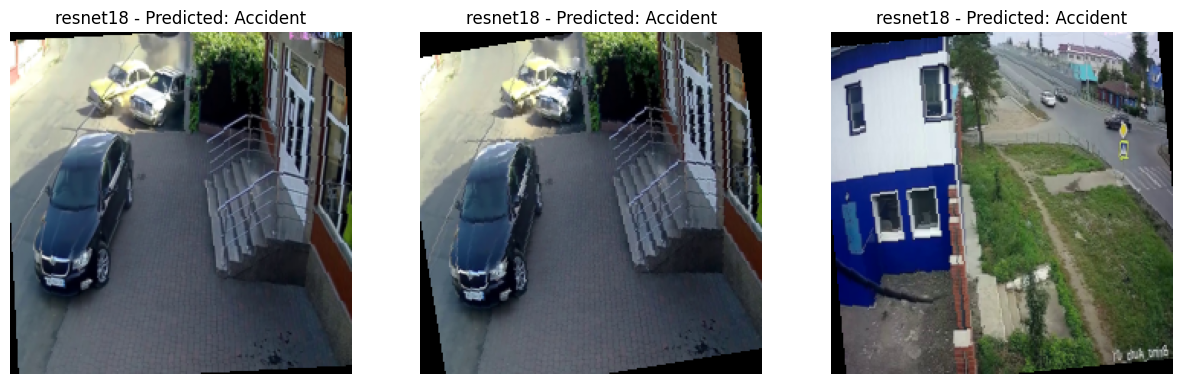

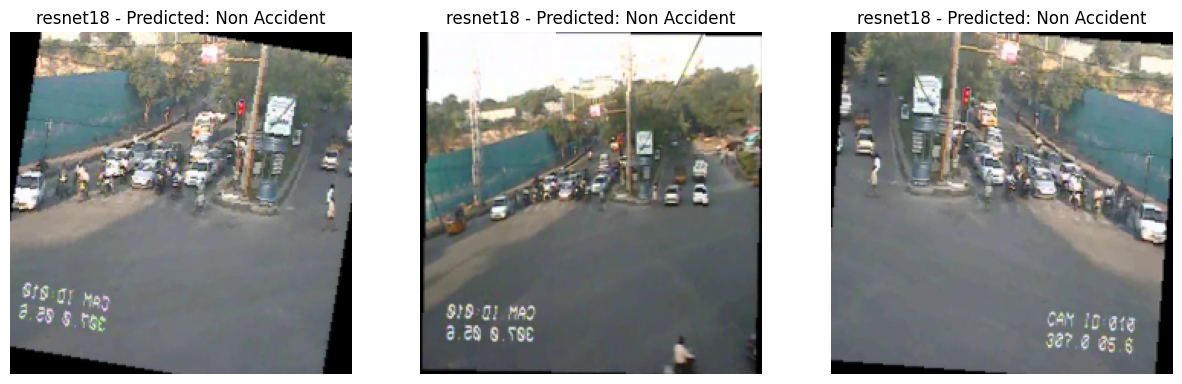


Displaying predicted images for mobilenet_v2...


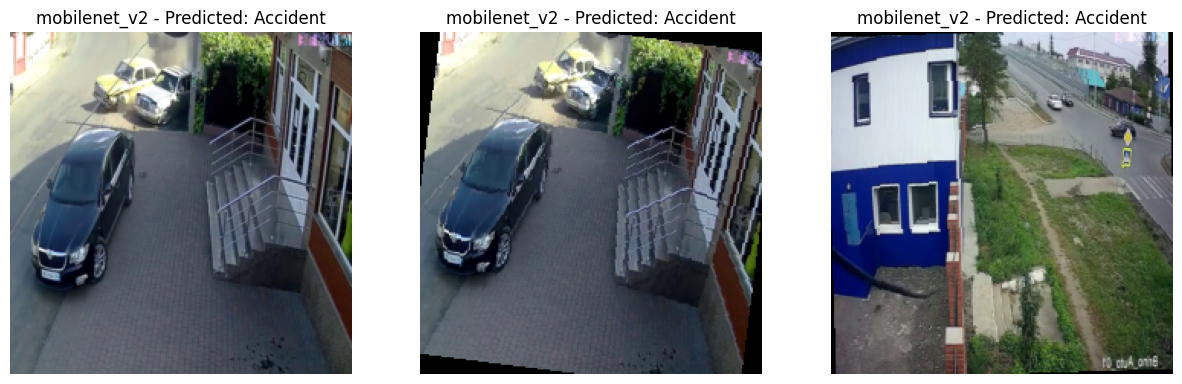

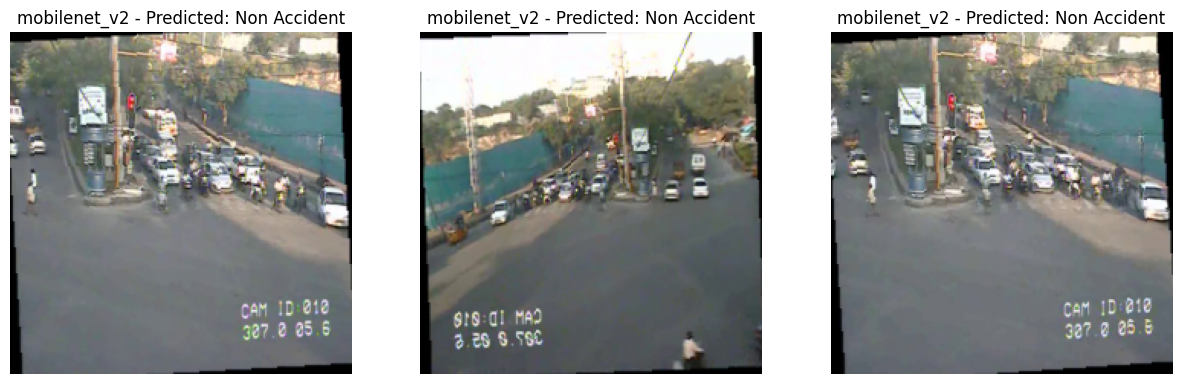


Displaying predicted images for efficientnet_b0...


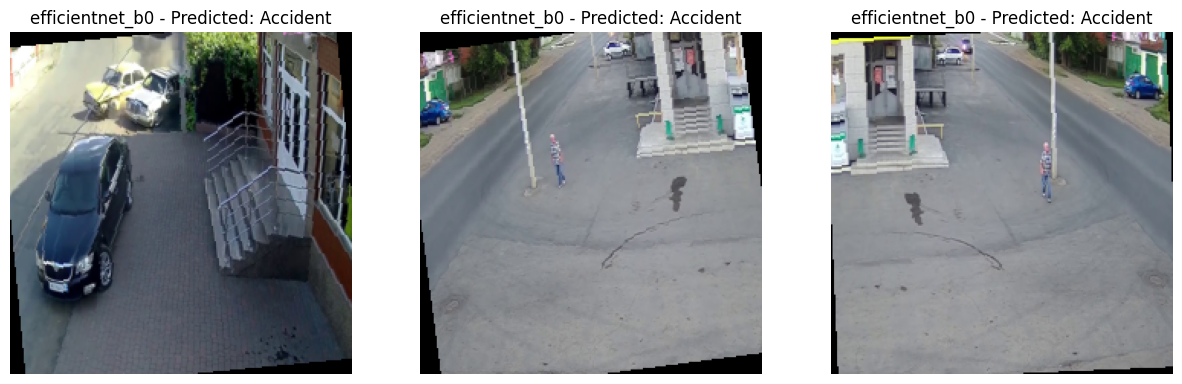

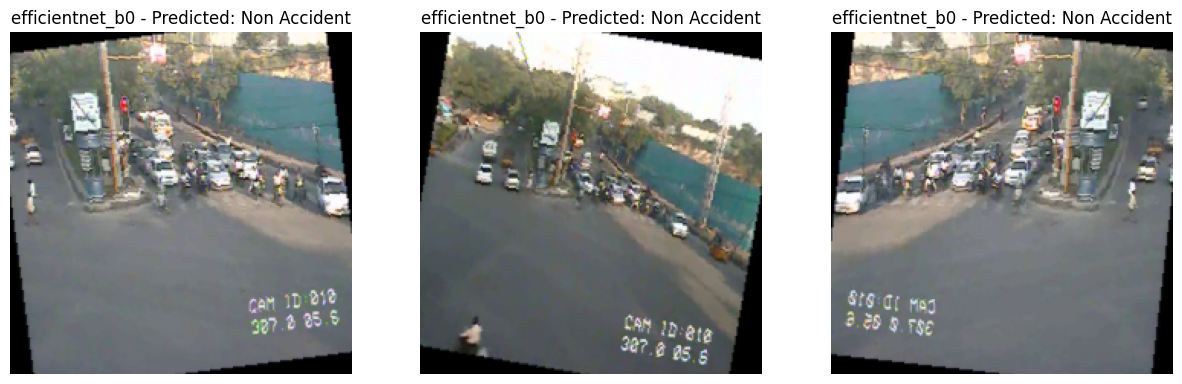

In [21]:
import matplotlib.pyplot as plt

def visualize_predictions(model, loader, device, num_images=3):
    model.eval()
    accident_images = []
    non_accident_images = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            labels = labels.cpu().numpy()

            for i in range(len(preds)):
                if preds[i] == 1 and len(accident_images) < num_images:
                    accident_images.append(inputs[i].cpu())
                elif preds[i] == 0 and len(non_accident_images) < num_images:
                    non_accident_images.append(inputs[i].cpu())

                if len(accident_images) >= num_images and len(non_accident_images) >= num_images:
                    break
            if len(accident_images) >= num_images and len(non_accident_images) >= num_images:
                break

    return accident_images, non_accident_images

# Set the number of images to display for each category
num_images = 3

# Display images predicted by each model
for i, model_path in enumerate(model_paths):
    model_name = results[i]['model_name']
    print(f'\nDisplaying predicted images for {model_name}...')

    # Reload the model
    if 'resnet' in model_name:
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, 1)
    elif 'mobilenet' in model_name:
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    elif 'efficientnet' in model_name:
        model = models.efficientnet_b0(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

    model.load_state_dict(torch.load(model_path))
    model = model.to(device)

    # Get predicted images
    accident_images, non_accident_images = visualize_predictions(model, val_loader, device, num_images=num_images)

    # Plot Accident Images
    plt.figure(figsize=(15, 5))
    for idx, img in enumerate(accident_images):
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
        img = img.numpy()
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.title(f'{model_name} - Predicted: Accident')
        plt.axis('off')
    plt.show()

    # Plot Non Accident Images
    plt.figure(figsize=(15, 5))
    for idx, img in enumerate(non_accident_images):
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
        img = img.numpy()
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.title(f'{model_name} - Predicted: Non Accident')
        plt.axis('off')
    plt.show()

